In [10]:
# تركيب المكتبات المطلوبة
!pip install plotly
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install imbalanced-learn

# استيراد المكتبات
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter


# قراءة البيانات
df = pd.read_excel('/content/Data_Train.xlsx')

# عرض المعلومات الأساسية عن البيانات
print("أبعاد البيانات:", df.shape)
print("\nمعلومات البيانات:")
print(df.info())
print("\nالقيم الفارغة:")
print(df.isnull().sum())
print("\nالإحصائيات الوصفية:")
print(df.describe())

أبعاد البيانات: (10001, 11)

معلومات البيانات:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10001 non-null  object
 1   Date_of_Journey  10001 non-null  object
 2   Source           10001 non-null  object
 3   Destination      10001 non-null  object
 4   Route            10000 non-null  object
 5   Dep_Time         10001 non-null  object
 6   Arrival_Time     10001 non-null  object
 7   Duration         10001 non-null  object
 8   Total_Stops      10000 non-null  object
 9   Additional_Info  10001 non-null  object
 10  Price            10001 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 859.6+ KB
None

القيم الفارغة:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops      

In [11]:
# Fill missing values in  and 'Route' with the mode
df['Total_Stops'] = df['Total_Stops'].fillna(df['Total_Stops'].mode()[0])
df['Route'] = df['Route'].fillna(df['Route'].mode()[0])

In [12]:
display(df.isnull().sum())

,0
Airline,0
Date_of_Journey,0
Source,0
Destination,0
Route,0
Dep_Time,0
Arrival_Time,0
Duration,0
Total_Stops,0
Additional_Info,0


In [13]:
from sklearn.preprocessing import FunctionTransformer

# 🕓 دالة لاستخراج ميزات التاريخ فقط
def extract_date_features(df):
    df = df.copy()
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], dayfirst=True)
    df['Journey_Day'] = df['Date_of_Journey'].dt.day
    df['Journey_Month'] = df['Date_of_Journey'].dt.month
    df['Journey_Year'] = df['Date_of_Journey'].dt.year
    df = df.drop(columns=['Date_of_Journey'])
    return df


# 🧹 دالة شاملة لتنظيف باقي الميزات (بدون التاريخ)
def clean_and_extract_features(df):
    df = df.copy()

    # ✈️ وقت الإقلاع
    df['Dep_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
    df['Dep_Minute'] = pd.to_datetime(df['Dep_Time']).dt.minute

    # ⏱️ المدة بالدقائق
    def convert_duration(duration):
        duration = duration.strip()
        if 'h' in duration and 'm' in duration:
            h, m = duration.split('h')
            return int(h) * 60 + int(m.replace('m', '').strip())
        elif 'h' in duration:
            return int(duration.replace('h', '').strip()) * 60
        elif 'm' in duration:
            return int(duration.replace('m', '').strip())
        return 0

    df['Duration_Minutes'] = df['Duration'].apply(convert_duration)

    # 🔁 عدد التوقفات
    df['Total_Stops'] = df['Total_Stops'].map({
        'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4
    })

    return df





# 🧩 تحويل خاص بعمود التاريخ
date_transformer = FunctionTransformer(extract_date_features)


In [14]:


# 🔧 تنظيف البيانات
df = clean_and_extract_features(df)

# 🟦 1. توزيع الأسعار
fig1 = px.histogram(df, x='Price', title='توزيع أسعار تذاكر الطيران')
fig1.show()

# 🟨 2. متوسط السعر حسب شركة الطيران
airline_avg = df.groupby('Airline')['Price'].mean().reset_index()
fig2 = px.bar(airline_avg, x='Airline', y='Price', title='متوسط السعر حسب شركة الطيران')
fig2.show()

# 🟩 3. العلاقة بين مدة الرحلة والسعر
fig3 = px.scatter(df, x='Duration_Minutes', y='Price', color='Airline',
                 title='العلاقة بين مدة الرحلة والسعر')
fig3.show()

# 🟧 4. العلاقة بين عدد التوقفات والسعر
fig4 = px.box(df, x='Total_Stops', y='Price', title='العلاقة بين عدد التوقفات والسعر')
fig4.show()

# 🟥 5. خريطة حرارية للارتباطات
corr = df.select_dtypes(include=[np.number]).corr()
fig5 = px.imshow(corr, text_auto=True, title='خريطة حرارية لارتباطات المتغيرات')
fig5.show()


/tmp/ipython-input-1033242137.py:19: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/tmp/ipython-input-1033242137.py:20: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [15]:


# فصل المتغيرات المستقلة (X) والمتغير المستهدف (y)
X = df.drop(['Price', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration'], axis=1)
y = df['Price']

# ✅ البيانات نظيفة بالفعل من مرحلة التنظيف السابقة، فلا حاجة لإعادة ملء القيم الفارغة

# عرض توزيع الأسعار قبل أي تحويل (اختياري للتحقق)
print("توزيع الأسعار (مقسّمة إلى فئات):")
print(Counter(pd.cut(y, bins=5)))

# 📉 تطبيق التحويل اللوغاريتمي لتقليل انحراف التوزيع
y_log = np.log1p(y)

# ✂️ تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)



print("✅ تم تجهيز البيانات بنجاح للنمذجة!")
print(f"🟢 أبعاد بيانات التدريب: {X_train.shape}")
print(f"🔵 أبعاد بيانات الاختبار: {X_test.shape}")


توزيع الأسعار (مقسّمة إلى فئات):
Counter({Interval(1681.247, 17309.6, closed='right'): 9760, Interval(17309.6, 32860.2, closed='right'): 226, Interval(32860.2, 48410.8, closed='right'): 8, Interval(48410.8, 63961.4, closed='right'): 6, Interval(63961.4, 79512.0, closed='right'): 1})
✅ تم تجهيز البيانات بنجاح للنمذجة!
🟢 أبعاد بيانات التدريب: (8000, 9)
🔵 أبعاد بيانات الاختبار: (2001, 9)


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ------------------ Pipeline ------------------
categorical_cols = ['Airline', 'Source', 'Destination', 'Additional_Info']
numeric_cols = [col for col in X.columns if col not in categorical_cols + ['Date_of_Journey']]

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('numeric', StandardScaler(), numeric_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('date_features', date_transformer),
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])


# الموديل
rf = RandomForestRegressor(random_state=42)

# باراميترات مع تركيز على تقليل overfitting
rf_params = {
    "model__n_estimators": [200, 500, 800, 1200],
    "model__max_depth": [10, 15],
    "model__min_samples_split": [5, 10, 15],
    "model__min_samples_leaf": [2, 4, 6, 8],
    "model__max_features": ["sqrt", "log2"],
    "model__bootstrap": [True, False]
}


# البحث العشوائي
rf_search = RandomizedSearchCV(
    pipeline, rf_params, n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=5, random_state=42, n_jobs=-1, verbose=2
)

rf_search.fit(X_train, y_train)








best_pipeline = rf_search.best_estimator_
print("Best Parameters:", rf_search.best_params_)





Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'model__n_estimators': 500, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 15, 'model__bootstrap': True}


Train Evaluation:
  MAE  = 0.13
  RMSE = 0.19
  R²   = 0.8690
  MAPE = 1.40%
----------------------------------------
Test Evaluation:
  MAE  = 0.14
  RMSE = 0.20
  R²   = 0.8503
  MAPE = 1.54%
----------------------------------------


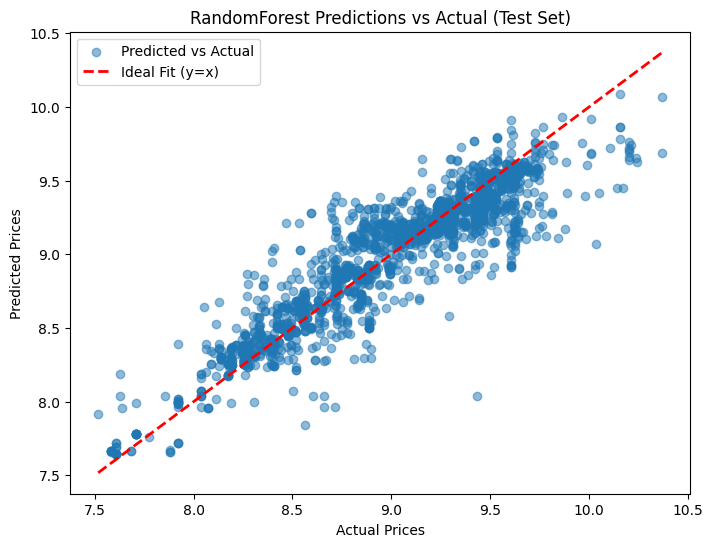

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# توقعات على train و test
y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

# دالة لحساب المقاييس
def evaluate(y_true, y_pred, dataset_name="Dataset"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"{dataset_name} Evaluation:")
    print(f"  MAE  = {mae:.2f}")
    print(f"  RMSE = {rmse:.2f}")
    print(f"  R²   = {r2:.4f}")
    print(f"  MAPE = {mape:.2f}%")
    print("-" * 40)

    return mae, rmse, r2, mape

# التقييم
train_scores = evaluate(y_train, y_train_pred, "Train")
test_scores = evaluate(y_test, y_test_pred, "Test")

# رسم النتائج
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--", lw=2, label="Ideal Fit (y=x)")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("RandomForest Predictions vs Actual (Test Set)")
plt.legend()
plt.show()


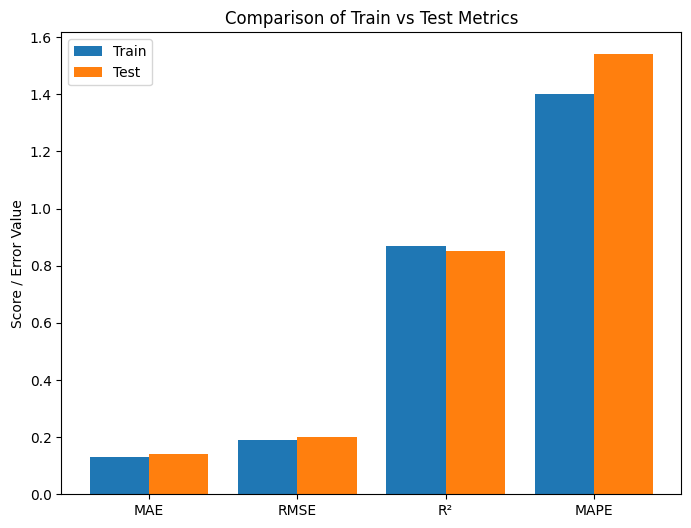

In [18]:
import matplotlib.pyplot as plt

# القيم اللي حسبتها قبل كده
metrics = ["MAE", "RMSE", "R²", "MAPE"]
train_scores = [0.13, 0.19,  0.8690, 1.40]
test_scores = [0.14, 0.20, 0.8503, 1.54]

x = range(len(metrics))

plt.figure(figsize=(8,6))
plt.bar(x, train_scores, width=0.4, label="Train", align="center")
plt.bar([i+0.4 for i in x], test_scores, width=0.4, label="Test", align="center")

plt.xticks([i+0.2 for i in x], metrics)
plt.ylabel("Score / Error Value")
plt.title("Comparison of Train vs Test Metrics")
plt.legend()
plt.show()


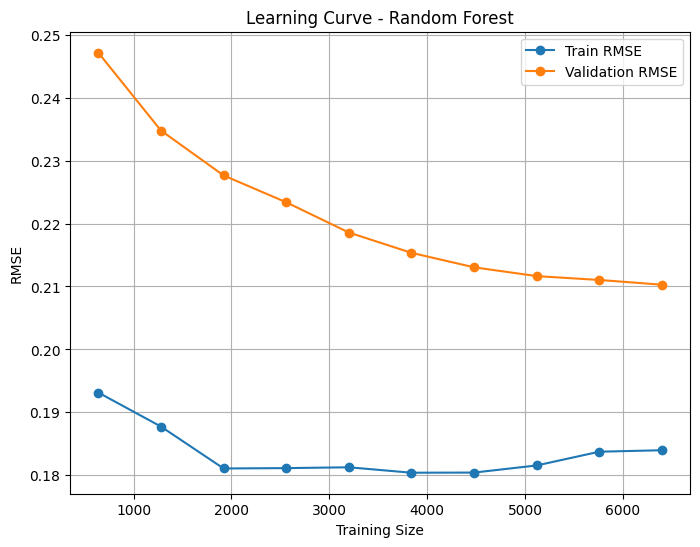

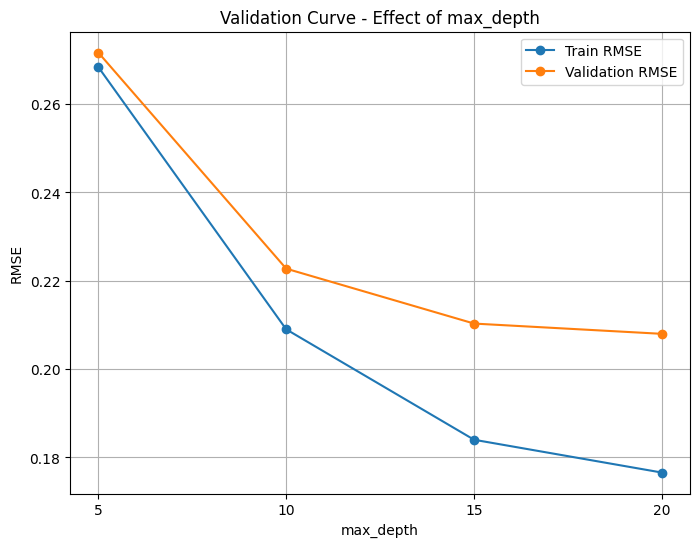

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve

#  Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline, X_train, y_train, cv=5,
    scoring="neg_root_mean_squared_error", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, "o-", label="Train RMSE")
plt.plot(train_sizes, test_mean, "o-", label="Validation RMSE")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

#  Validation Curve (مثال على max_depth)
param_range = [ 5,10, 15, 20 ]
train_scores, test_scores = validation_curve(
    best_pipeline, X_train, y_train,
    param_name="model__max_depth", param_range=param_range,
    cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot([str(p) for p in param_range], train_mean, "o-", label="Train RMSE")
plt.plot([str(p) for p in param_range], test_mean, "o-", label="Validation RMSE")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.title("Validation Curve - Effect of max_depth")
plt.legend()
plt.grid(True)
plt.show()

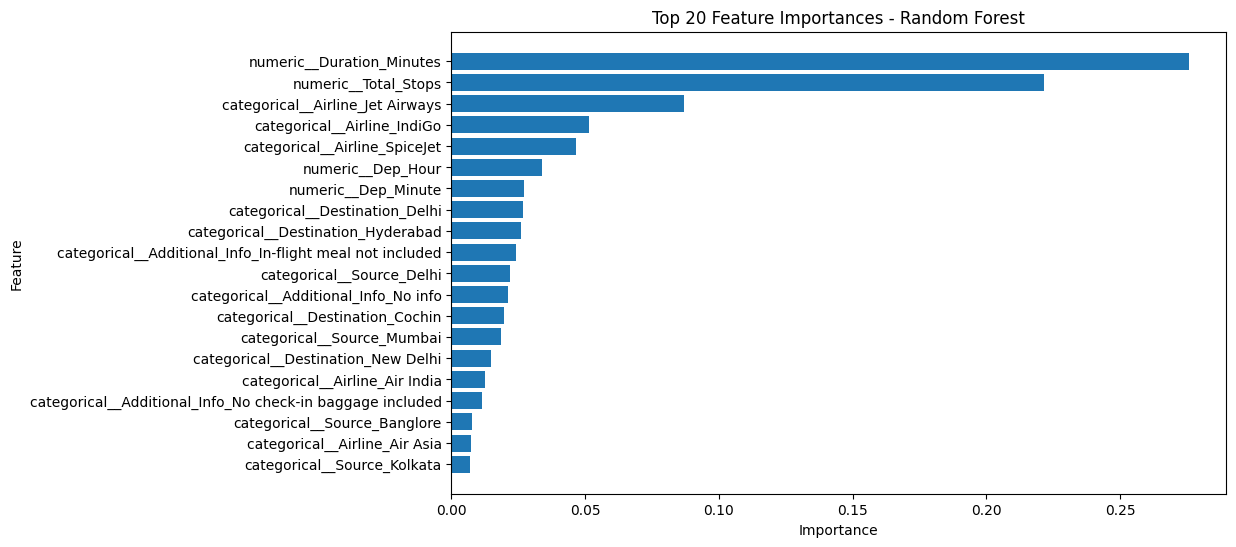

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# استخراج أسماء الأعمدة بعد الـ Preprocessing (OneHot + Numeric)
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

# استخراج الأهمية من الموديل
importances = best_pipeline.named_steps['model'].feature_importances_

# نرتبهم في DataFrame عشان يبقى سهل عرضهم
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# عرض أول 20 مثلاً
plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"][:20][::-1], feat_imp["Importance"][:20][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()


In [21]:
import joblib

# حفظ الموديل
joblib.dump(best_pipeline, "best_model.pkl")
print("✅ تم حفظ الموديل كامل في best_model.pkl")

✅ تم حفظ الموديل كامل في best_model.pkl
